In [1]:
import wrap_technote as tn
import dew_gwdata as gd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

In [2]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 130
plt.rcParams["figure.figsize"] = (6, 3)

In [3]:
db = gd.sageodata()

In [71]:
w = "NGK027"

In [86]:
wls = db.water_levels(db.find_wells(w)).dropna(subset=["rswl", "obs_date"], how="any")
wls = wls.groupby(wls.obs_date.dt.year).rswl.max()

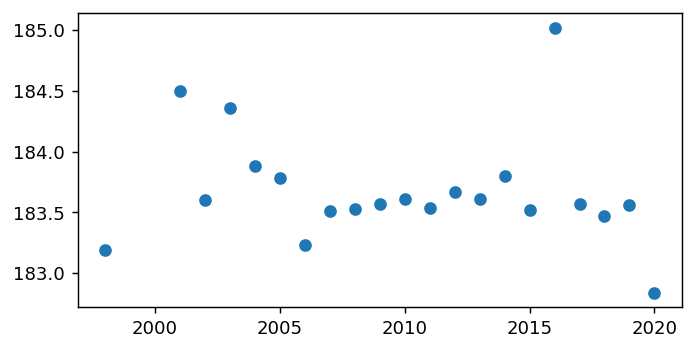

In [87]:
plt.scatter(wls.index, wls)

In [88]:
tn.bom_percentiles

array([  0,   5,  20,  50,  80,  95, 100])

In [89]:
def get_class_value_ranges(
    s,
    upper_interval_boundaries=(10, 30, 70, 90, 100),
    interval_names=(
        "Very much below average",
        "Below average",
        "Average",
        "Above average",
        "Very much above average",
    ),
):
    vmin = s.min()
    vmax = s.max()
    vrange = s.max() - s.min()
    upper_interval_values = np.array(
        [vmin + (pct / 100) * vrange for pct in upper_interval_boundaries]
    )

    intervals = []
    lower = vmin
    for i in range(len(upper_interval_values)):
        upper = upper_interval_values[i]
        name = interval_names[i]
        intervals.append((name, lower, upper))
        lower = upper
    return intervals

In [90]:
get_class_value_ranges(wls)

[('Very much below average', 182.84, 183.058),
 ('Below average', 183.058, 183.494),
 ('Average', 183.494, 184.366),
 ('Above average', 184.366, 184.80200000000002),
 ('Very much above average', 184.80200000000002, 185.02)]

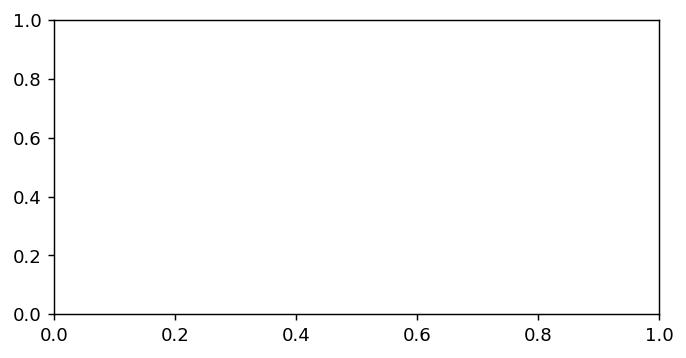

In [91]:
def rank_and_classify(s, param_name=""):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if param_name != "":
        param_name += "_"
    new_df = pd.DataFrame(index=s.index)

    intervals = get_class_value_ranges(s)

    vmin = s.min()
    vmax = s.max()

    def map_value_to_vpcts(v):
        if v == vmin:
            return "Lowest on record"
        elif v == vmax:
            return "Highest on record"
        else:
            for name, lower, upper in intervals:
                if v > lower and v <= upper:
                    return name

    #     lower = vmin
    #     for i in range(len(vpcts)):
    #         c = tn.bom_classes[1:-1][i]
    #         upper = vpcts[i]
    #         ax.axhspan(lower, upper, label=c, color=bcmap.class_to_rgba(c))
    #         lower = upper

    #     ax.legend()

    new_df[f"{param_name}bom_class"] = s.map(map_value_to_vpcts)
    return new_df


old = tn.rank_and_classify(wls)
new = rank_and_classify(wls)

In [92]:
old

,percentile,bom_class
obs_date,,
1998,9.523810,Very much below average
2001,95.238095,Very much above average
2002,57.142857,Average
2003,90.476190,Very much above average
2004,85.714286,Above average
2005,76.190476,Above average
2006,14.285714,Below average
2007,23.809524,Below average
2008,33.333333,Average


In [93]:
new

,bom_class
obs_date,
1998,Below average
2001,Above average
2002,Average
2003,Average
2004,Average
2005,Average
2006,Below average
2007,Average
2008,Average


In [94]:
bcmap = tn.BoMClassesColormap()

Text(0, 0.5, 'RSWL')

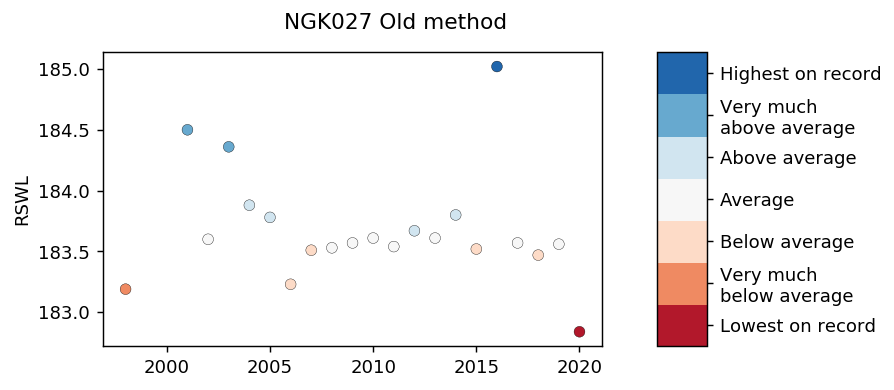

In [95]:
fig, axes = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=(10, 1)))

axes[0].scatter(
    old.index,
    wls.values,
    c=[bcmap.class_to_rgba(c) for c in old.bom_class],
    edgecolor="k",
    linewidth=0.2,
    marker="o",
)


bcmap.plot_legend(axes[1])
fig.suptitle(f"{w} Old method")
axes[0].set_ylabel("RSWL")

Text(0, 0.5, 'RSWL')

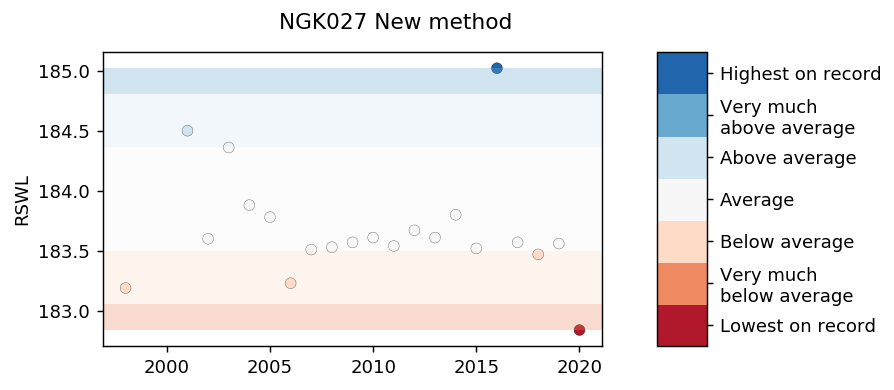

In [96]:
fig, axes = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=(10, 1)))

intervals = get_class_value_ranges(wls)
for name, lower, upper in intervals:
    axes[0].axhspan(lower, upper, facecolor=bcmap.class_to_rgba(name), alpha=0.3)

axes[0].scatter(
    new.index,
    wls.values,
    c=[bcmap.class_to_rgba(c) for c in new.bom_class],
    edgecolor="k",
    linewidth=0.2,
    marker="o",
)

bcmap.plot_legend(axes[1])
fig.suptitle(f"{w} New method")
axes[0].set_ylabel("RSWL")